<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/klasifikasi_covid_19_dan_pneumonia.UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
!pip install --upgrade tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import shutil
import random
import cv2
import zipfile
import matplotlib.cm as cm

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Progbar
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model  # Correct import path for plot_model
from tensorflow.keras.utils import get_custom_objects
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# **Delete Old Directory**

In [ ]:
try:
    shutil.rmtree("./train")
    shutil.rmtree("./test")
    shutil.rmtree("./val")

except OSError as e:
    print("Directories never existed")

Directories never existed


# **CREATE DIRECTORY and SPLIT into TRAIN, TEST, VALIDATION**

In [ ]:
path = "../input/covid19normalpneumonia-ct-images"
classesPath = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']

np.random.seed(seed = 90)

val_ratio = 0.1
test_ratio = 0.1
seed = 90

for cls in classesPath:
    os.makedirs('./train/' + cls)
    os.makedirs('./val/' + cls)
    os.makedirs('./test/' + cls)

    src = path + "/" + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                               int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total ', str(cls), len(allFileNames))
    print('Training', len(train_FileNames))
    print('Validation', len(val_FileNames))
    print('Testing', len(test_FileNames))
    print("\n")

    for name in train_FileNames:
        shutil.copy(name, './train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, './val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, './test/' + cls)

Total  COVID2_CT 2035
Training 1628
Validation 203
Testing 204


Total  Normal_CT 2119
Training 1695
Validation 212
Testing 212


Total  pneumonia_CT 3390
Training 2712
Validation 339
Testing 339




# **Creating image data generator for training and testing**

In [ ]:
path_train = "./train"
path_val = "./val"
path_test = "./test"

batch_size = 32
batch_test_size = 16
seed = 90
interpolation = "bicubic"
target_size = (256, 256)
epochs = 50

train_data_gen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,  # Geser gambar secara horizontal sebesar 10% lebar gambar
                                    height_shift_range=0.1, # Geser gambar secara vertikal sebesar 10% tinggi gambar
                                    shear_range=0.2,        # Miringkan gambar dengan rentang 20 derajat
                                    zoom_range=0.2,         # Perbesar atau perkecil gambar hingga 20%
                                    horizontal_flip=True,  # Putar gambar secara horizontal secara acak
                                    fill_mode='nearest')    # Isi piksel yang kosong dengan nilai terdekat)


test_data_gen = ImageDataGenerator()

ds_train = train_data_gen.flow_from_directory(directory = path_train,
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              target_size = target_size,
                                              shuffle = True,
                                              interpolation = interpolation,
                                              seed = seed)

ds_val = test_data_gen.flow_from_directory(directory = path_val,
                                           color_mode = "rgb",
                                           batch_size = batch_size,
                                           class_mode='categorical',
                                           target_size = target_size,
                                           shuffle = True,
                                           interpolation = interpolation,
                                           seed = seed)

ds_test = test_data_gen.flow_from_directory(directory = path_test,
                                            color_mode = "rgb",
                                            batch_size = batch_test_size,
                                            target_size = target_size,
                                            class_mode='categorical',
                                            shuffle = False,
                                            interpolation = interpolation,
                                            seed = seed)

Found 6035 images belonging to 3 classes.
Found 754 images belonging to 3 classes.
Found 755 images belonging to 3 classes.


# **MODEL CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

# Define the input shape based on your image dimensions
input_shape = (256, 256, 3)  # Replace height, width, and channels with actual values
# Definisikan model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3))  # Menggunakan tiga unit karena ada tiga kelas
model.add(Activation('softmax'))  # Aktivasi softmax untuk klasifikasi multikelas


model.summary()




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 252, 252, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 252, 252, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 57, 57, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 57, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       295,16

 Total params: 20,054,563 (76.50 MB)

 Trainable params: 20,051,619 (76.49 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Nadam

# Tentukan lokasi penyimpanan model terbaik dengan ekstensi .keras
filepath = "best_model_3.keras"

# Definisikan ModelCheckpoint untuk menyimpan model terbaik berdasarkan validasi accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

# List semua callbacks yang akan digunakan (tanpa EarlyStopping)
callbacks_list = [checkpoint]

# Compile model dengan optimizer dan loss function yang sesuai
model.compile(optimizer=Nadam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Tentukan jumlah epoch yang diinginkan
epochs = 50

# Latih model dengan generator data pelatihan dan validasi, sambil menggunakan callbacks
history = model.fit(ds_train, epochs=epochs, validation_data=ds_val, shuffle=True, callbacks=callbacks_list)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717170440.887427      92 service.cc:145] XLA service 0x7e9ea00093e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717170440.887480      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-05-31 15:47:24.457627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 5.22285, expected 4.50617
2024-05-31 15:47:24.457690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 19: 4.83523, expected 4.11855
2024-05-31 15:47:24.457704: E external/local_xla/xla/service/g

  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:35:12 30s/step - accuracy: 0.1562 - loss: 1.6463

I0000 00:00:1717170456.856334      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/189 ━━━━━━━━━━━━━━━━━━━━ 1:12 808ms/step - accuracy: 0.3843 - loss: 1.3040

2024-05-31 15:48:58.994587: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258064: 5.29023, expected 4.65911
2024-05-31 15:48:58.994652: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258071: 5.27604, expected 4.64492
2024-05-31 15:48:58.994663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258095: 5.17345, expected 4.54233
2024-05-31 15:48:58.994672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258103: 5.25027, expected 4.61914
2024-05-31 15:48:58.994680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258136: 4.89888, expected 4.26776
2024-05-31 15:48:58.994689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258172: 5.28037, expected 4.64925
2024-05-31 15:48:58.994709: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 258220: 4.86592, expected 4.2348
2024-05-31 15:48:58.994718: 

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.4291 - loss: 1.2220

2024-05-31 15:50:22.350032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 6.59745, expected 5.63898
2024-05-31 15:50:22.350102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 6.54158, expected 5.58311
2024-05-31 15:50:22.350112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 7.1846, expected 6.22613
2024-05-31 15:50:22.350121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 7.4221, expected 6.46364
2024-05-31 15:50:22.350131: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 8.08683, expected 7.12837
2024-05-31 15:50:22.350140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 7.49463, expected 6.53616
2024-05-31 15:50:22.350149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 7.7101, expected 6.75163
2024-05-31 15:50:22.350170: E external/local_xla/xla/service/gpu/

189/189 ━━━━━━━━━━━━━━━━━━━━ 199s 895ms/step - accuracy: 0.4294 - loss: 1.2212 - val_accuracy: 0.6618 - val_loss: 0.7889
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 162s 825ms/step - accuracy: 0.6217 - loss: 0.8256 - val_accuracy: 0.7905 - val_loss: 0.4739
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 158s 807ms/step - accuracy: 0.6953 - loss: 0.6690 - val_accuracy: 0.8117 - val_loss: 0.4136
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 799ms/step - accuracy: 0.7362 - loss: 0.6054 - val_accuracy: 0.8183 - val_loss: 0.4215
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 158s 805ms/step - accuracy: 0.7693 - loss: 0.5261 - val_accuracy: 0.8369 - val_loss: 0.3573
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 155s 788ms/step - accuracy: 0.7971 - loss: 0.4711 - val_accuracy: 0.8316 - val_loss: 0.3675
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 155s 791ms/step - accuracy: 0.8076 - loss: 0.4391 - val_accuracy: 0.8223 - val_loss: 0.4627
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 156s 798ms/step - accuracy: 0.8305 - loss: 0.39

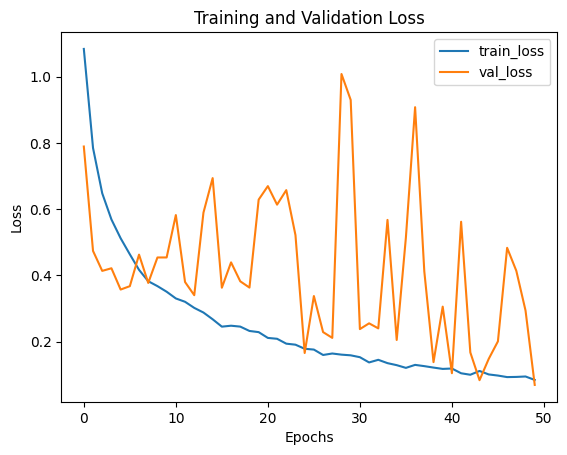

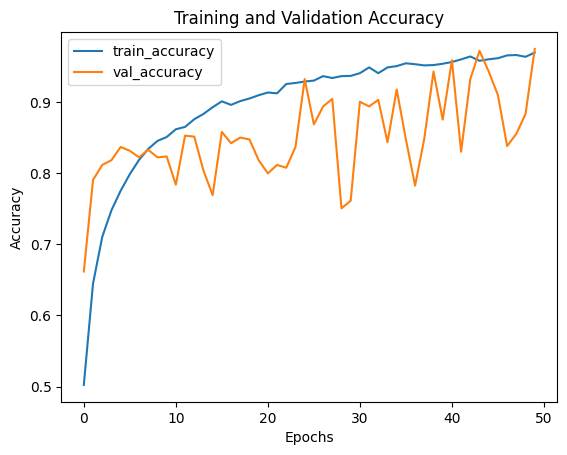

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


**Train**

In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2024-05-31 17:59:35.069948: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129032: 6.23419, expected 5.28448
2024-05-31 17:59:35.070015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129033: 6.10421, expected 5.15451
2024-05-31 17:59:35.070025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129034: 7.09771, expected 6.148
2024-05-31 17:59:35.070035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129035: 8.03191, expected 7.08221
2024-05-31 17:59:35.070044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129036: 7.06707, expected 6.11736
2024-05-31 17:59:35.070054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129037: 7.7164, expected 6.76669
2024-05-31 17:59:35.070063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129038: 8.14916, expected 7.19946
2024-05-31 17:59:35.070071: E 

47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9572 - loss: 0.1297

2024-05-31 17:59:43.114693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64516: 6.18098, expected 5.39172
2024-05-31 17:59:43.114771: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64517: 6.55985, expected 5.77059
2024-05-31 17:59:43.114790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64535: 6.50052, expected 5.71126
2024-05-31 17:59:43.114810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64536: 5.76942, expected 4.98016
2024-05-31 17:59:43.114826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64546: 5.63759, expected 4.84833
2024-05-31 17:59:43.114839: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64547: 5.26415, expected 4.47489
2024-05-31 17:59:43.114852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64548: 6.22564, expected 5.43638
2024-05-31 17:59:43.114864: E exte

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9577 - loss: 0.1282
Test Loss: 0.09302733838558197
Test Accuracy: 0.9695364236831665


**Confusion Matrix**

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step


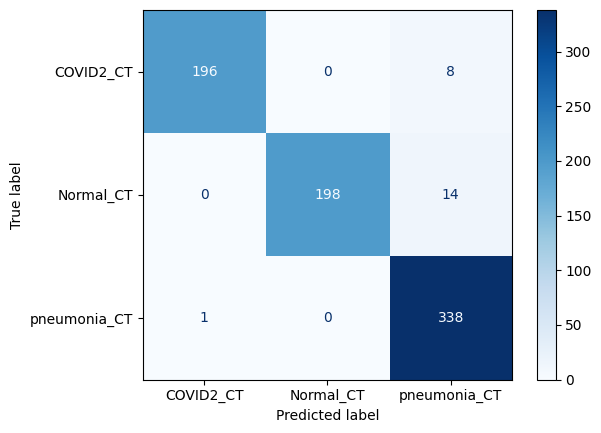

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Muat model terbaik yang disimpan selama pelatihan
best_model = load_model(filepath)

# Prediksi pada data uji menggunakan model terbaik
y_pred_prob = best_model.predict(ds_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya
y_true = ds_test.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ds_test.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **ResNet50**

In [ ]:
model_ResNet = ResNet50V2(weights='imagenet',include_top=False)
full_name = "ResNet_Model"

x = model_ResNet.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_ResNet = Model(inputs=model_ResNet.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/ResNet"):
    os.makedirs('./Weights/ResNet')

filepath = "./Weights/ResNet/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_ResNet, show_shapes = True, show_layer_names = True, to_file = "ResNet.png")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('./Weights/ResNet/ResNet_Model-Final-{epoch:02d}-{val_accuracy:.4f}.keras', monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_ResNet.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

historyResNet = model_ResNet.fit(ds_train, epochs=epochs, validation_data=ds_val, shuffle=True, callbacks=callbacks_list)


Epoch 1/50


I0000 00:00:1717178490.320235      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 4 bytes spill stores, 4 bytes spill loads



112/189 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.7668 - loss: 0.5316   

I0000 00:00:1717178603.702911      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 4 bytes spill stores, 4 bytes spill loads



189/189 ━━━━━━━━━━━━━━━━━━━━ 256s 981ms/step - accuracy: 0.8160 - loss: 0.4295 - val_accuracy: 0.8674 - val_loss: 0.2981
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 162s 828ms/step - accuracy: 0.9678 - loss: 0.0867 - val_accuracy: 0.9430 - val_loss: 0.1505
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 160s 816ms/step - accuracy: 0.9782 - loss: 0.0593 - val_accuracy: 0.8939 - val_loss: 0.3360
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 161s 819ms/step - accuracy: 0.9820 - loss: 0.0502 - val_accuracy: 0.9045 - val_loss: 0.3267
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 161s 824ms/step - accuracy: 0.9865 - loss: 0.0387 - val_accuracy: 0.9960 - val_loss: 0.0119
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 160s 814ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9324 - val_loss: 0.1986
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 811ms/step - accuracy: 0.9899 - loss: 0.0289 - val_accuracy: 0.9814 - val_loss: 0.0421
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 160s 815ms/step - accuracy: 0.9934 - loss: 0.02

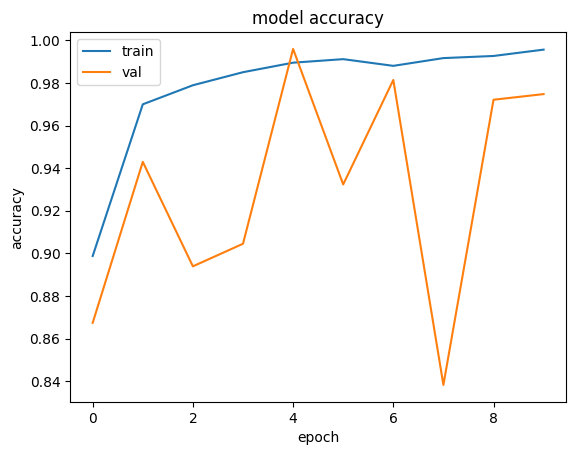

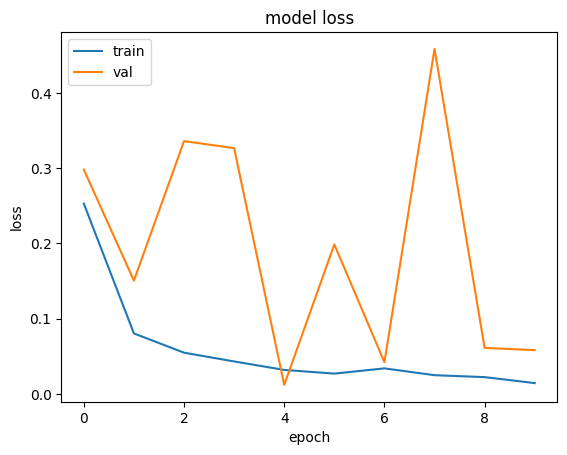

In [ ]:
plt.plot(historyResNet.history['accuracy'])
plt.plot(historyResNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyResNet.history['loss'])
plt.plot(historyResNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_accuracy = model_ResNet.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9964 - loss: 0.0062
Test Loss: 0.018459374085068703
Test Accuracy: 0.9920529723167419
